In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
import time
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-02-04 11:47:36.607300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 11:47:36.816544: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-04 11:47:36.820921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 11:47:36.820939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
real_data = getListOfReadsFromFastaFile("data/RealData/fasta_of_merged_50_50.fas")

In [3]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

## Data experiment

In [6]:
pre_processing_times = []
maximization_times = []
shapley_estimation_times = []
ref_calculation_times = []
counter_factual_calc_times = []
general_time_for_all = []
dataset_sizes = [10,20,30,40,50]


In [7]:
for size in dataset_sizes:
    biggest = int(size / 2)
    second = int((size - biggest)/2)
    third = size - biggest - second
    print(biggest, second, third)
    number_of_sapienses = biggest
    number_of_neanderthals = second
    number_of_denisovans = third
    dataset_1 = neanderthals_500_generated[:number_of_neanderthals] + sapiens_500_generated[:number_of_sapienses] + denisovan_500_samples[:number_of_denisovans]
    start_all = time.perf_counter()
    maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)
    after_pre_processing = time.perf_counter()
    time_of_preprocessing = after_pre_processing - start_all
    pre_processing_times.append(time_of_preprocessing)
    print("finish_1")
    
    estimation = maximum_likelihood_calculator_d_1.estimate_species_proportions(result_resolution=50)
    after_maximization = time.perf_counter()
    time_of_maximization = after_maximization - after_pre_processing
    maximization_times.append(time_of_maximization)
    print("finish_2")

    shapleys = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read=50)[0] #[0] is to get the scaled values
    after_shapley = time.perf_counter()
    time_of_shapley = after_shapley - after_maximization
    shapley_estimation_times.append(time_of_shapley)
    print("finish_3")
    
    ref = maximum_likelihood_calculator_d_1.analyze_diff_on_removing_reference(number_of_samples=100,size_of_sample=8,result_resolution=50)
    after_ref_calculation = time.perf_counter()
    time_of_ref_calculation = after_ref_calculation - after_shapley
    ref_calculation_times.append(time_of_ref_calculation)
    print("finish_4")
    
    cf = maximum_likelihood_calculator_d_1.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)
    after_counter_factual = time.perf_counter()
    time_of_cf_calculation = after_counter_factual - after_ref_calculation
    counter_factual_calc_times.append(time_of_cf_calculation)
    print("finish_5")
    
    general_time_for_all.append(after_counter_factual - start_all)
    print(general_time_for_all)

5 2 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  10
First DNA sequence from input dataset: TGTAACTTACTACTCCGGAAAAAAAGAACCATTTGGATACATAGGTATGA
start working on read number 0
finish_1
finish_2
finish_3
finish_4
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [6]
finish_5
[51.770758229999046]
10 5 5
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  20
First DNA sequence from input dataset: TGTAACTTACTACTCCGGAAAAAAAGAACCATTTGGATACATAGGTATGA
start working on read number 0
finish_1
finish_2
finish_3
finish_4
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 19]
finish_5
[51.770758229999046, 100.77480483300315]
15 7 8
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  30
First DNA sequence from input dataset: TGTAACTTACTACTCCGGAAAAA

In [8]:
counter_factual_calc_times

[0.04345966300024884,
 0.1304631730017718,
 0.3233256790044834,
 0.5948736819991609,
 0.9145649059937568]

In [15]:
def plot(t,s, name, title):

    plt.scatter(t, s)
    plt.title(title)
    plt.xlabel("Dataset size")
    plt.ylabel("Execution time in seconds")
    plt.savefig(name)

    plt.show()

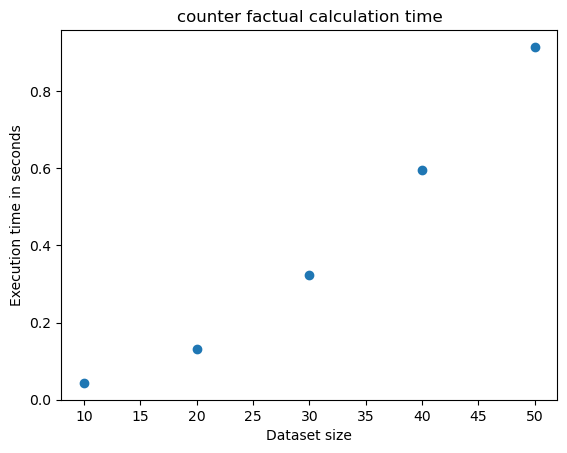

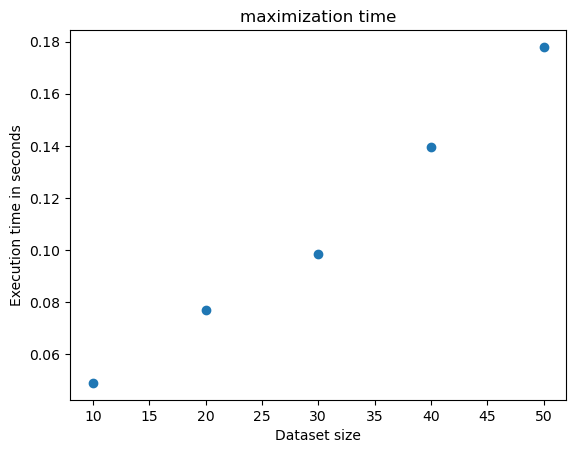

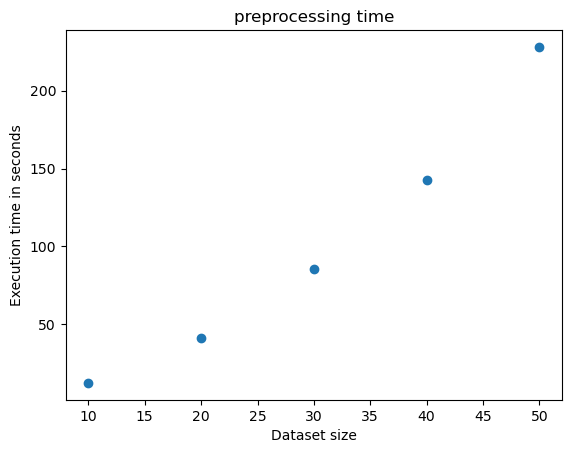

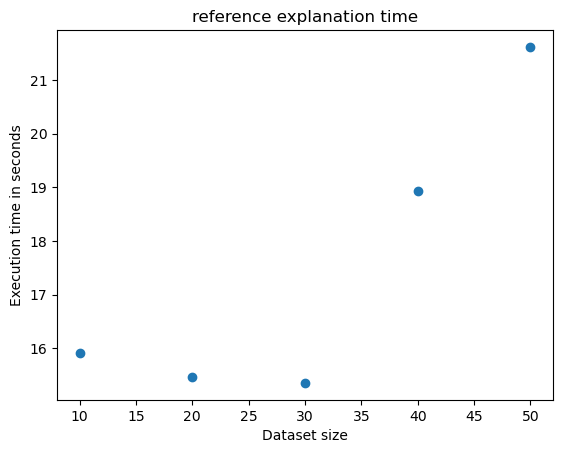

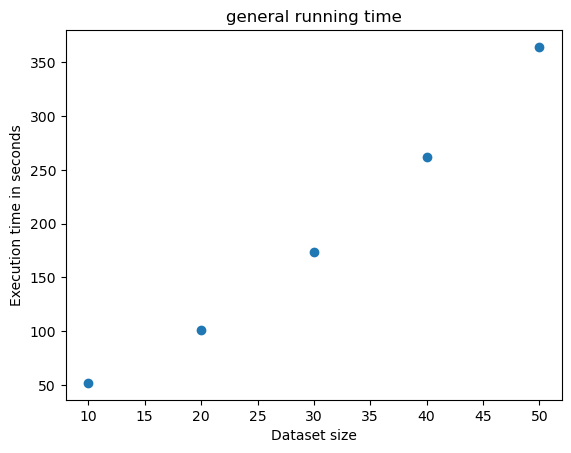

In [18]:
plot(dataset_sizes, counter_factual_calc_times, "counterfactual_GeneratedDataSizePlot.png", "counter factual calculation time")
plot(dataset_sizes, maximization_times, "maximization_GeneratedDataSizePlot.png", "maximization time")
plot(dataset_sizes, shapley_estimation_times, "shapley_GeneratedDataSizePlot.png", "preprocessing time")
plot(dataset_sizes, ref_calculation_times, "reference_GeneratedDataSizePlot.png", "reference explanation time")
plot(dataset_sizes, general_time_for_all, "generalTime_GeneratedDataSizePlot.png", "general running time")


# Threads

In [ ]:
times = []
for num_of_threads in [1,2,4,6,8,10,12,14,16]:
    tic = time.perf_counter()
    maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(real_data,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=num_of_threads)
    toc = time.perf_counter()
    print(f"Took {toc - tic:0.4f} seconds")
    times.append(toc-tic)
    print(times)

In [12]:

# Data for plotting
t = [1,2,4,6,8]
s = times[:5]

plt.scatter(t, s)
plt.xlabel("Number of threads")
plt.ylabel("Execution time in seconds")
plt.savefig("realdatamaximumLikelihoodToTimebasedOnNumOfThreads.png")

plt.show()

NameError: name 'times' is not defined